<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>DC2 Patch 4431 Analysis Notebook</b> <br>
Contact author: Erin Howard<br>
Last verified to run: November 29, 2022<br>
LSST Science Piplines version: w_2022_39<br>
Container Size: Large <br>

# DM-36026: ApPipe on DC2, October 2022

New baseline run, still using "old diffim" (before the big refactor).

* Uses `DC2` skymap
* Templates from four goodSeeingCoadd patches 4431 (DC2) are in `/sdf/group/rubin/repo/main/u/elhoward/DM-36026/templates/20221025T211333Z`
* Final processing of DC2 patch_4431 is in `u/elhoward/DM-36026/DC2-4patch_4431-full`
* Postgres schema is `elhoward_dm36026_dc2_appipe`
* Working directory on USDF with bps logs, pipelines, etc. is `/project/elhoward/repo-main-logs/DM-36026`

For ApTemplate.yaml:
```
inCollection: u/mrawls/DM-34827/defaults/4patch_4431
dataQuery: "skymap='DC2'"
```
For ApPipe.yaml:
```
inCollection: u/mrawls/DM-34827/defaults/4patch_4431,u/elhoward/DM-36026/templates/20221025T211333Z
dataQuery: "skymap='DC2'"
```

## Table of Contents

1. Loading DiaObjects and DiaSources
2. Typical "quick look analysis" plots
3. SNR distributions

In [1]:
%matplotlib widget

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyCoaddAnalysis
from lsst.analysis.ap import legacyPlotUtils as plac

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-5.0.0/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


<module 'lsst.analysis.ap.legacyApdbUtils' from '/sdf/data/rubin/u/elhoward/repos/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py'>

## 1. Loading DiaObjects and DiaSources

In [2]:
repo = '/repo/dc2'
butler = dafButler.Butler(repo)
collections = 'u/elhoward/DM-36026/DC2-4patch_4431-full' #payloadName from bps yaml
instrument = 'LSSTCam-imSim'
skymap = 'DC2'
schema = 'elhoward_dm36026_dc2_appipe'

dbType='postgres'
dbName='lsst-devl'

month = 'October'
year = '2022'

In [3]:
objTable, srcTable, goodObj, goodSrc = utils.loadTables(repo,
                                                      dbName=dbName,
                                                      dbType=dbType,
                                                      instrument=instrument,
                                                      schema=schema)

In [4]:
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = utils.makeSrcTableFlags(srcTable, objTable,
                                                                                 instrument=instrument,
                                                                                 repo=repo)

In [5]:
objTable.columns

Index(['diaObjectId', 'ra', 'decl', 'nDiaSources', 'gPSFluxMean',
       'rPSFluxMean', 'iPSFluxMean', 'zPSFluxMean', 'yPSFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

In [6]:
srcTable.columns

Index(['diaSourceId', 'diaObjectId', 'ra', 'decl', 'ccdVisitId', 'midPointTai',
       'apFlux', 'psFlux', 'apFluxErr', 'psFluxErr', 'totFlux', 'totFluxErr',
       'x', 'y', 'snr', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'flags', 'filterName',
       'visit', 'detector', 'instrument'],
      dtype='object')

## 2. Typical "quick look analysis" plots

Text(0.5, 1.0, 'All DIA Objects, October 2022')

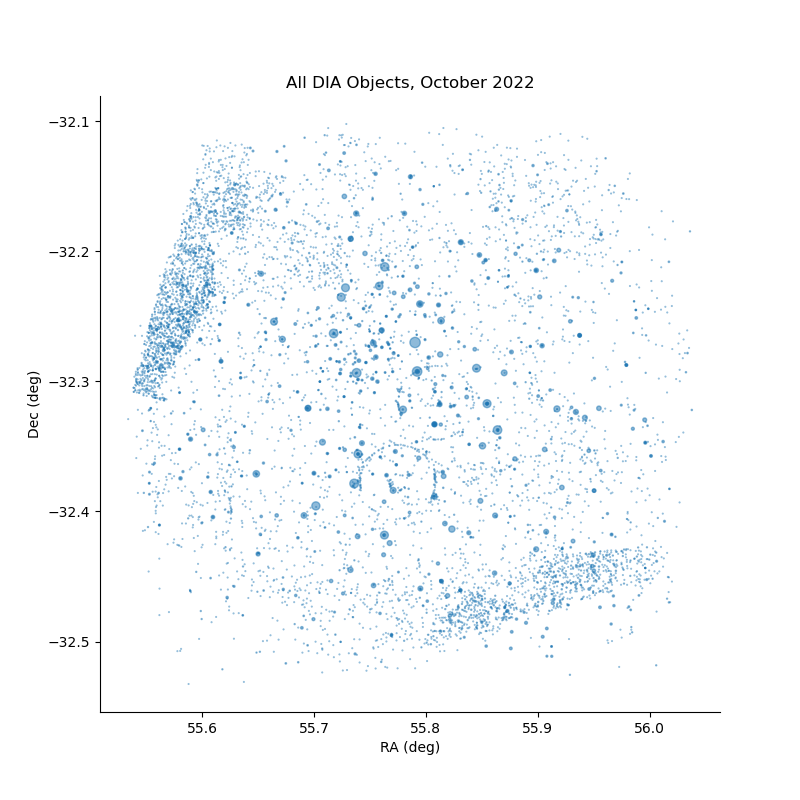

In [7]:
fig = plt.figure(figsize=(8,8))

cutoff = 0  # only plot DIA Objects composed more than cutoff DIA Sources

ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources'], marker='.', alpha=0.5)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'All DIA Objects, {month} {year}')

Text(0.5, 1.0, 'DIA Objects composed of > 2 "Good" DIA Sources, October 2022')

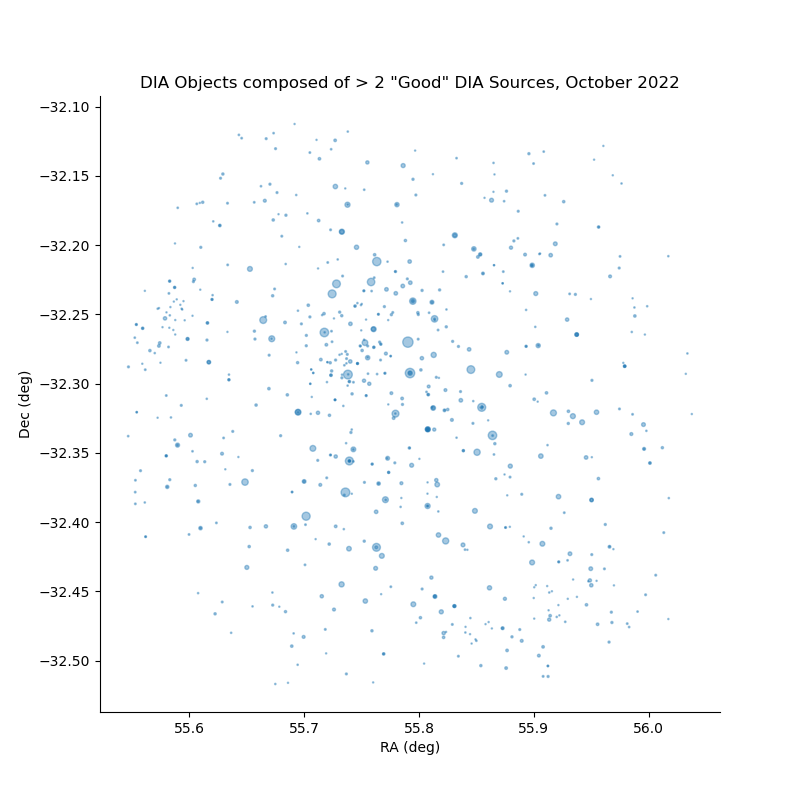

In [8]:
fig = plt.figure(figsize=(8,8))

cutoff = 2  # only plot DIA Objects composed more than cutoff DIA Sources

ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources'], marker='.', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'DIA Objects composed of > {cutoff} "Good" DIA Sources, {month} {year}')

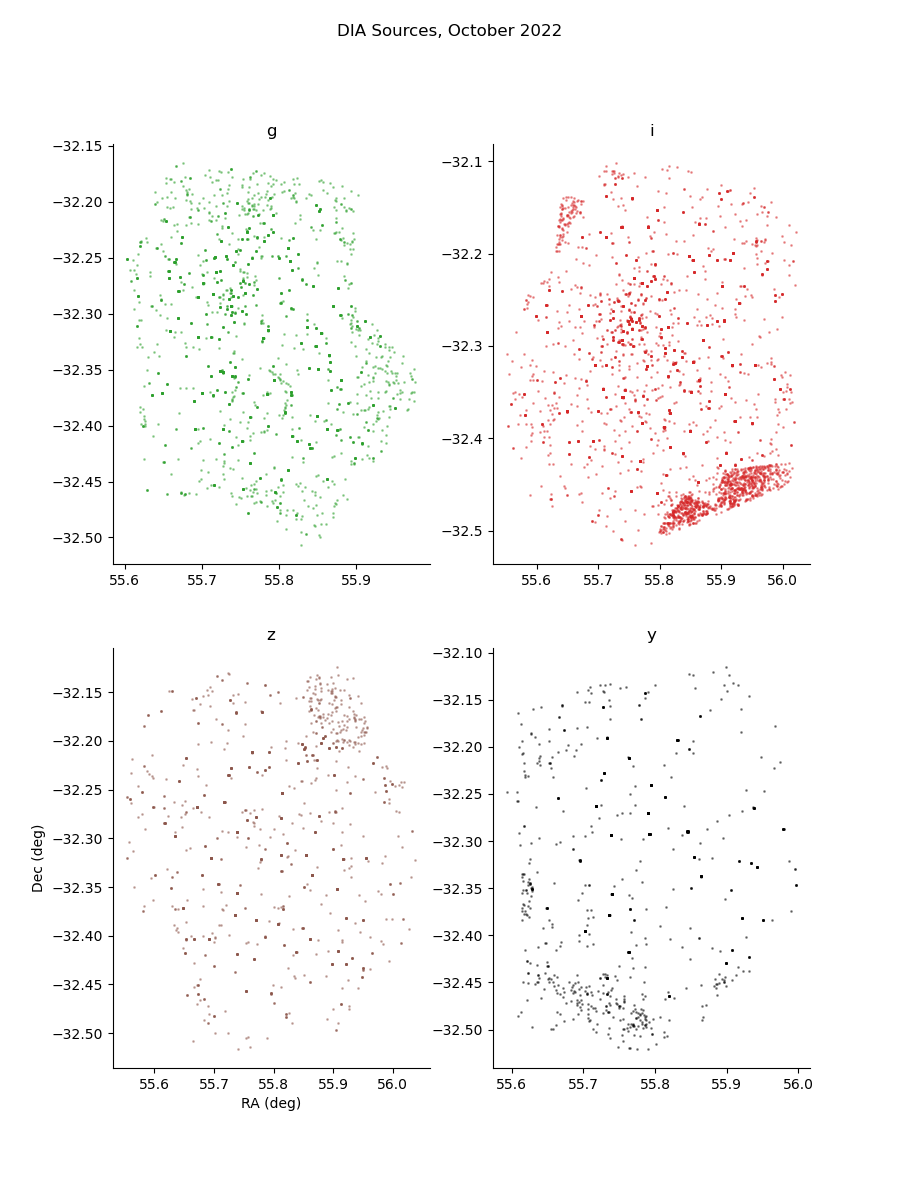

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(9, 12))

axG = axs[0, 0]
axI = axs[0, 1]
axZ = axs[1, 0]
axY = axs[1, 1]

axList = [axG, axI, axZ, axY]
colorList = ['C2', 'C3', 'C5', 'k']

fig.suptitle(f'DIA Sources, {month} {year}')
pSize = 1

goodGFilter = (goodSrc['filterName'] == 'g')
goodIFilter = (goodSrc['filterName'] == 'i')
goodZFilter = (goodSrc['filterName'] == 'z')
goodYFilter = (goodSrc['filterName'] == 'y')

filterList = [goodGFilter, goodIFilter, goodZFilter, goodYFilter]

for ax, filtered, color in zip(axList, filterList, colorList):
    ax.scatter(goodSrc.loc[filtered, 'ra'], goodSrc.loc[filtered, 'decl'], c=color, s=pSize, marker='o', alpha=0.4)

axZ.set_xlabel('RA (deg)')
axZ.set_ylabel('Dec (deg)')

axG.set_title('g')
axI.set_title('i')
axZ.set_title('z')
axY.set_title('y')

for ax in axList:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

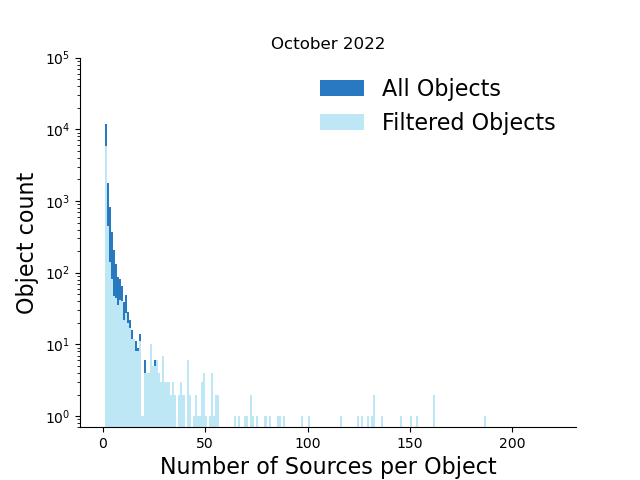

In [10]:
hist = plac.plotDiaObjectHistogram(objTable, goodObj, title=f'{month} {year}')

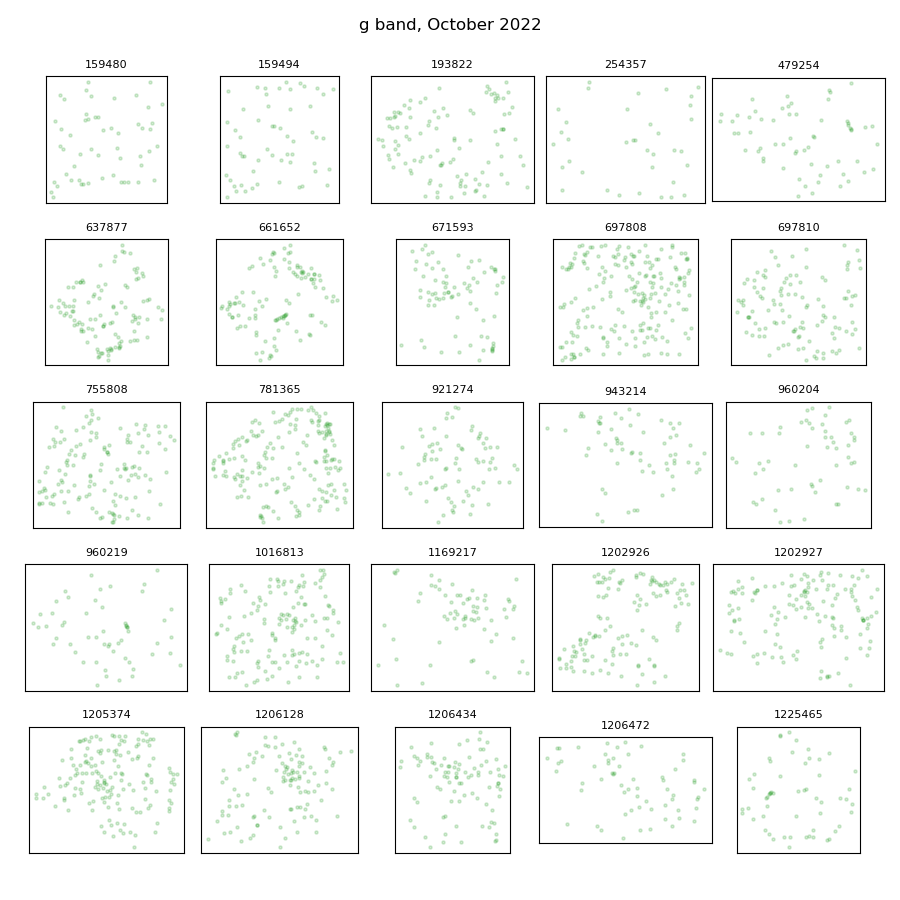

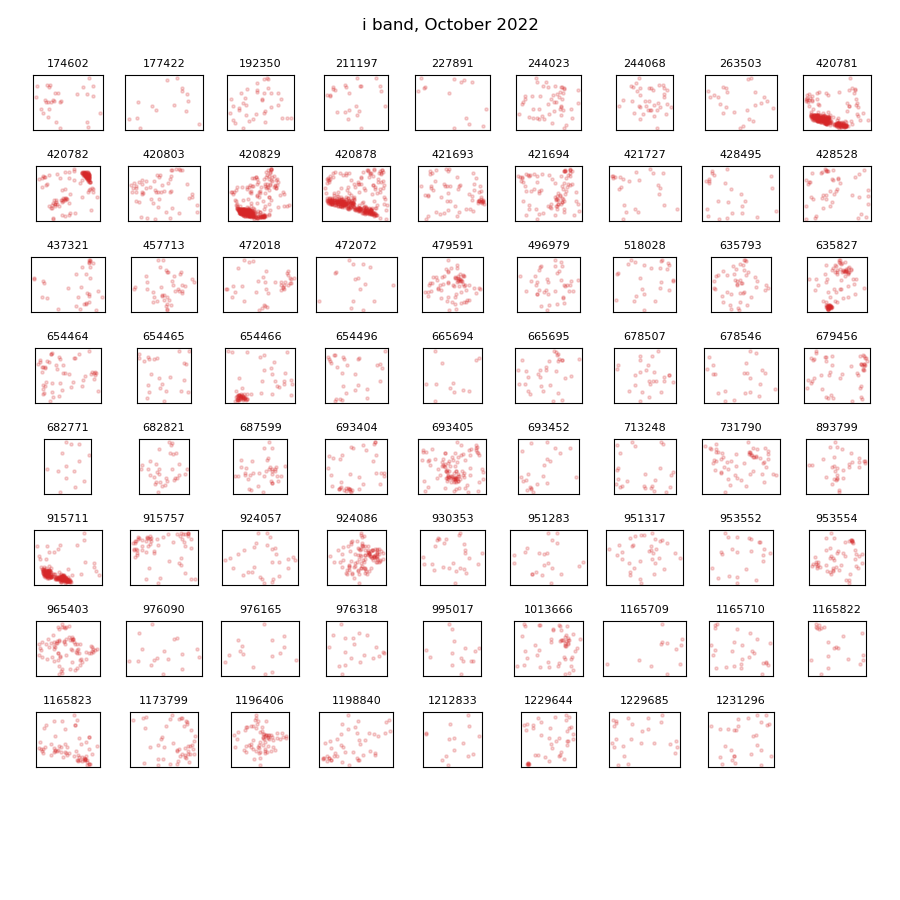

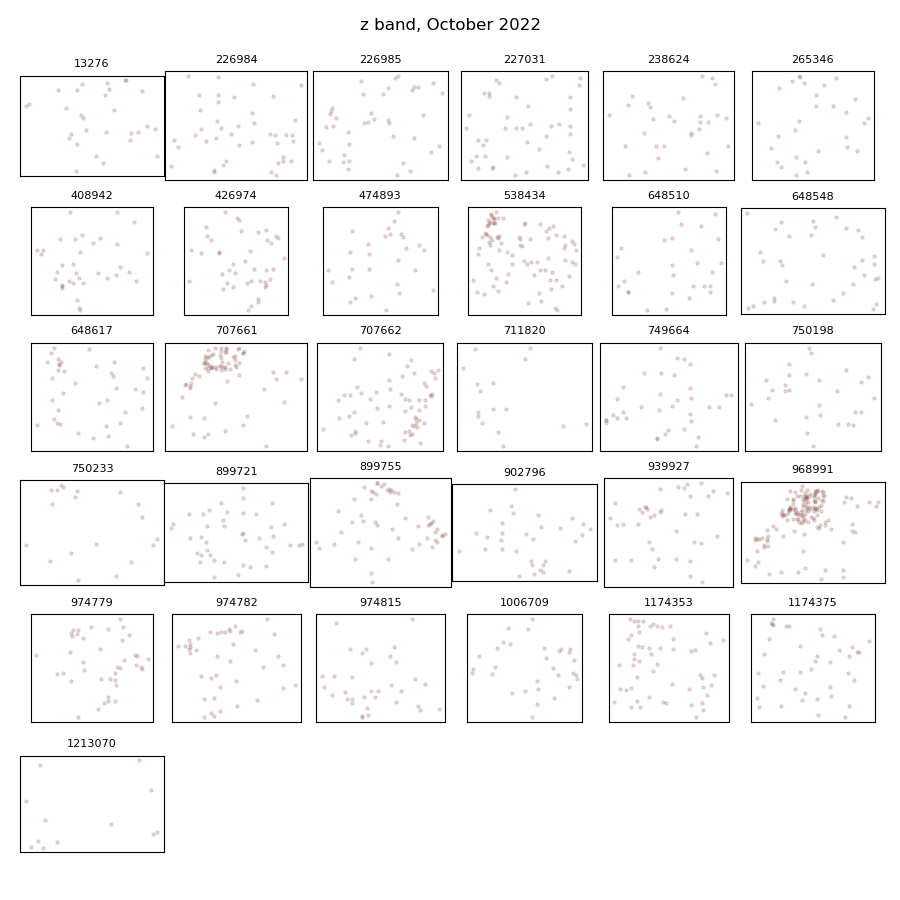

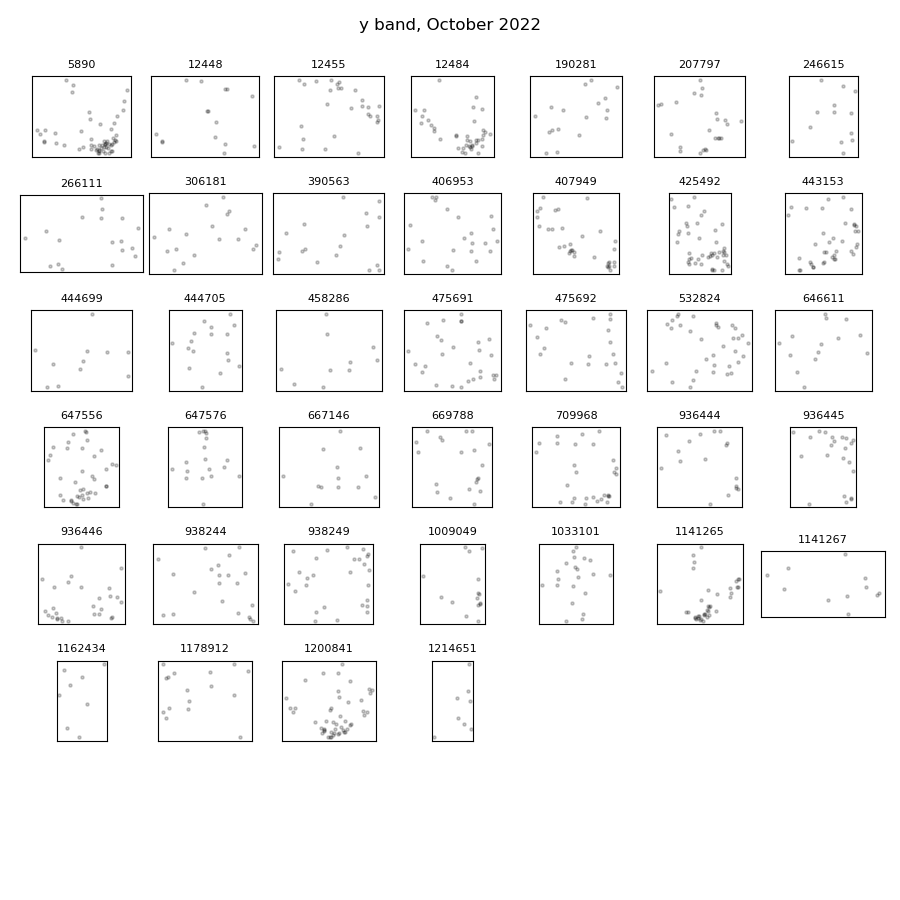

In [11]:
bandList = ['g', 'i', 'z', 'y']
colorList = ['C2', 'C3', 'C5', 'k']

for band, color in zip(bandList, colorList):
    plac.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band], title=band+f' band, {month} {year}', color=color, size=20)

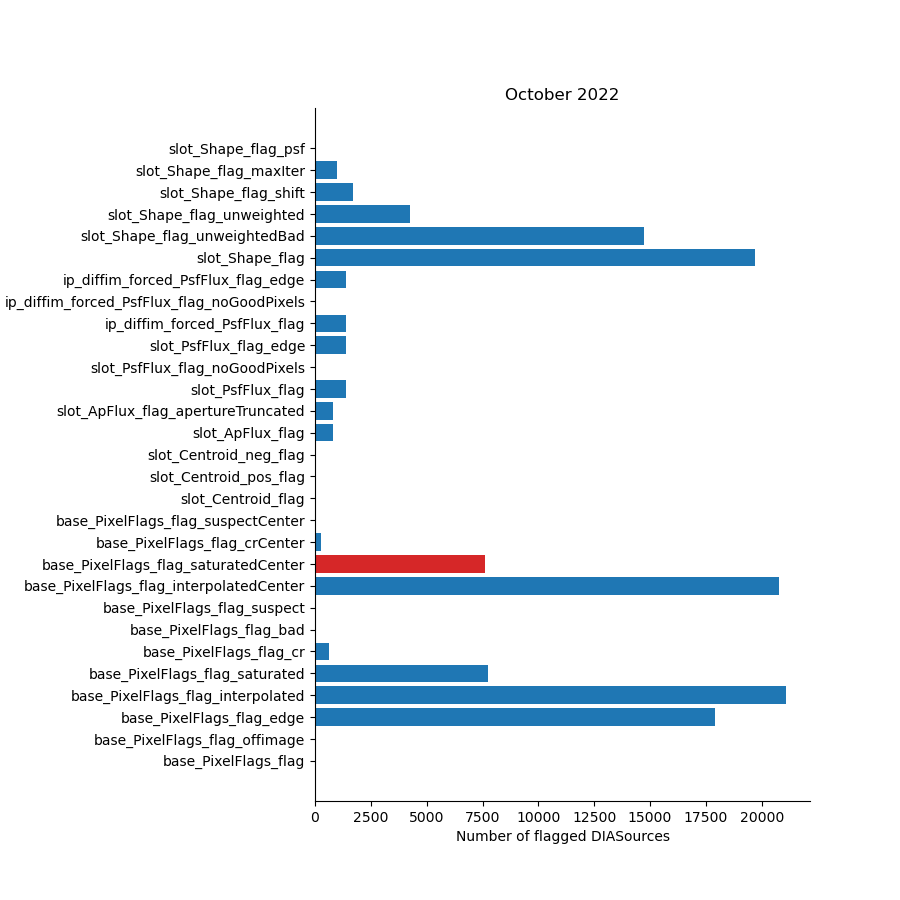

In [12]:
plac.plotFlagHist(srcTable, title=f'{month} {year}')

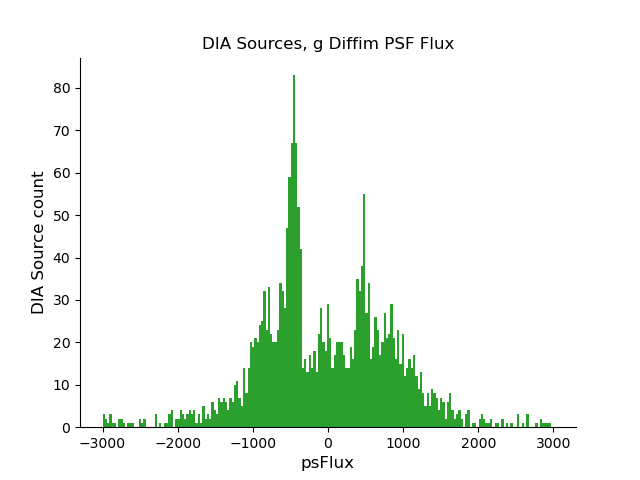

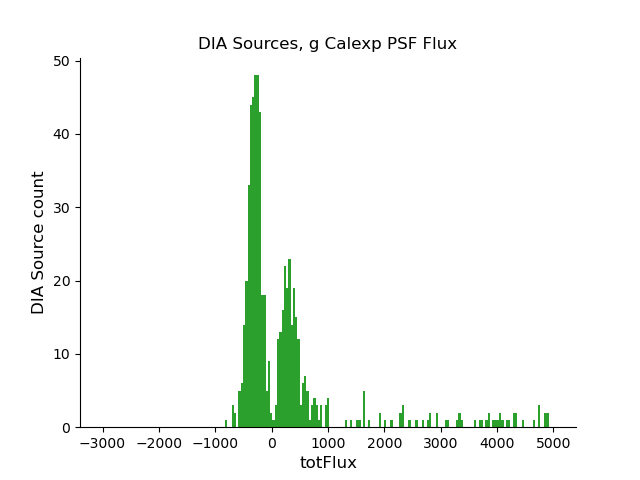

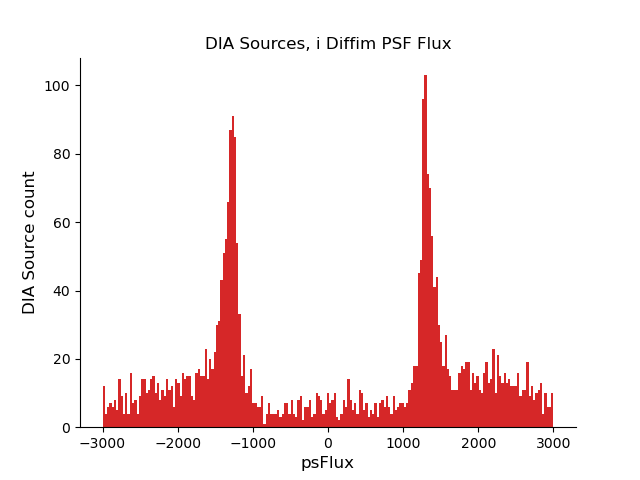

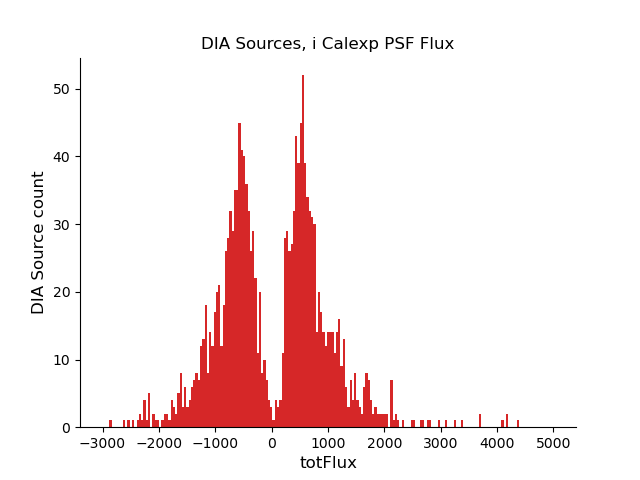

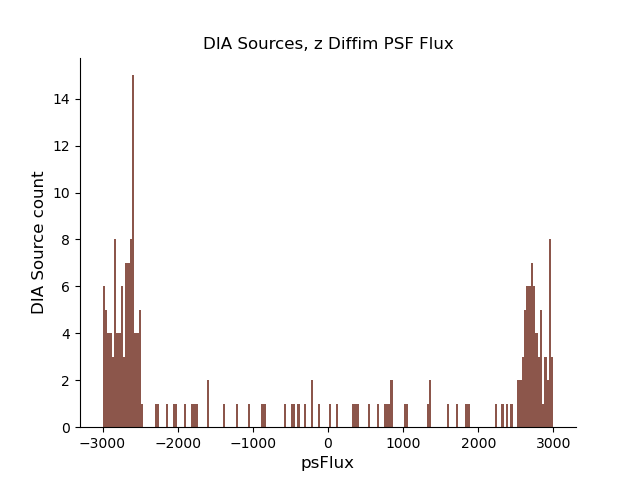

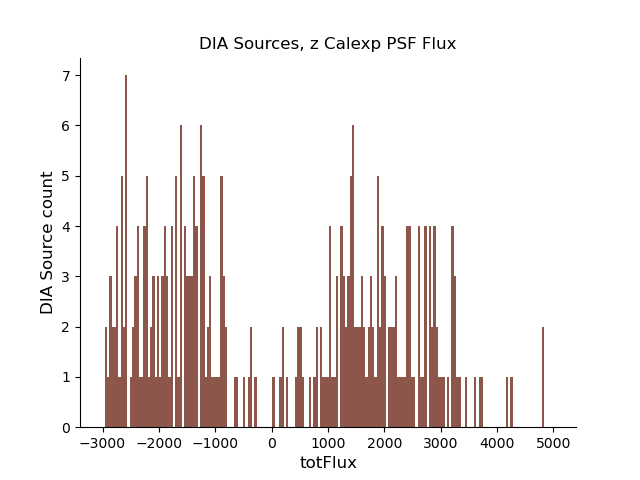

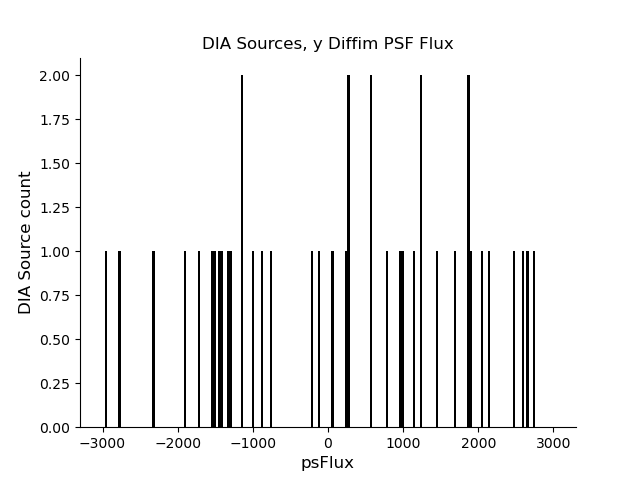

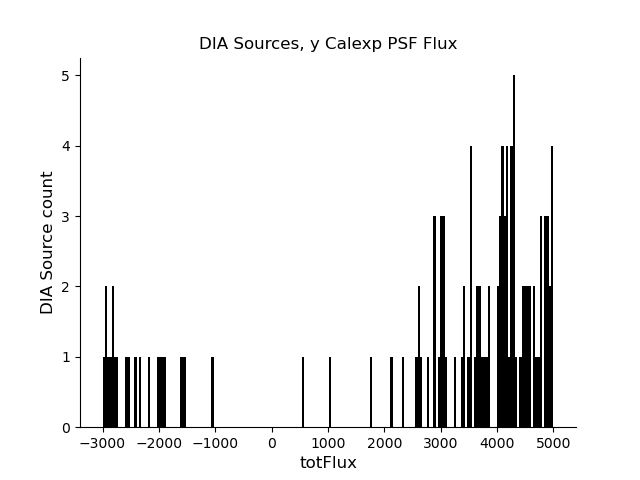

In [13]:
for band, color in zip(bandList, colorList):
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='psFlux',
                        title=f'DIA Sources, {band} Diffim PSF Flux', color1=color, binmin=-3e3, binmax=3e3)
    plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='totFlux',
                        title=f'DIA Sources, {band} Calexp PSF Flux', color1=color, binmin=-3e3, binmax=5e3)

## 3. SNR distributions

For both difference image fluxes (psFlux) and forced source photometry fluxes (totFlux)

In [14]:
# SNR is basically just flux/fluxErr for our purposes
# There is now an actual `snr` column in the DiaSource table too, even better!

Text(0.5, 0, 'SNR of DIA Sources')

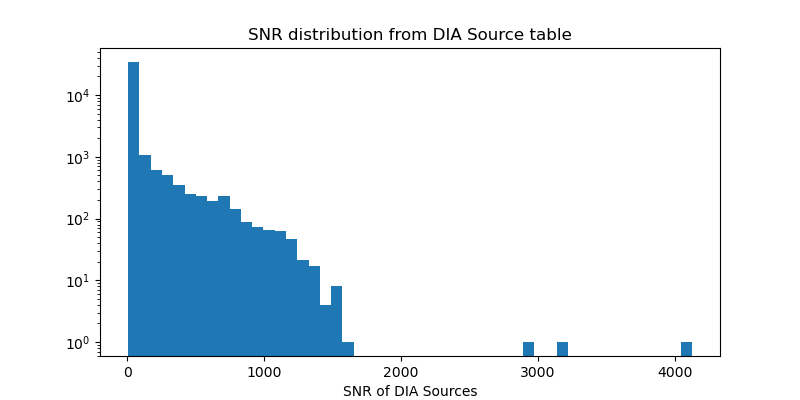

In [15]:
plt.figure(figsize=(8,4))
plt.yscale('log')
snrHist = plt.hist(srcTable.snr, bins=50)
plt.title('SNR distribution from DIA Source table')
plt.xlabel('SNR of DIA Sources')

In [16]:
# Pre-snr column:
srcTable['psFluxSNR'] = srcTable.psFlux / srcTable.psFluxErr
srcTable['totFluxSNR'] = srcTable.totFlux / srcTable.totFluxErr

Text(0.5, 0, 'psFlux/psFluxErr')

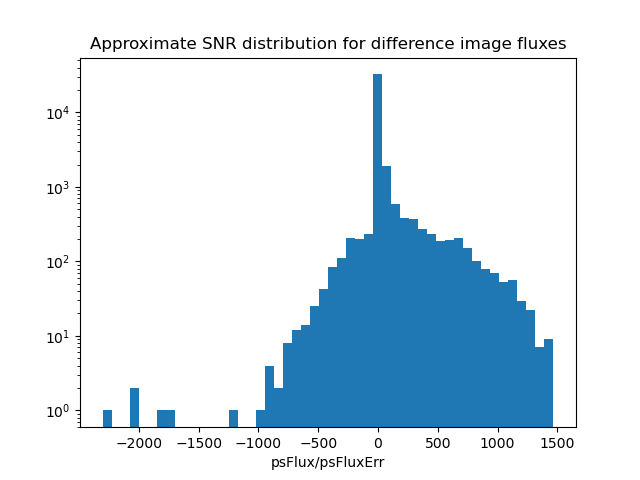

In [17]:
plt.figure()
plt.yscale('log')
psFluxHist = plt.hist(srcTable.psFluxSNR, bins=50)
plt.title('Approximate SNR distribution for difference image fluxes')
plt.xlabel('psFlux/psFluxErr')

Text(0.5, 0, 'totFlux/totFluxErr')

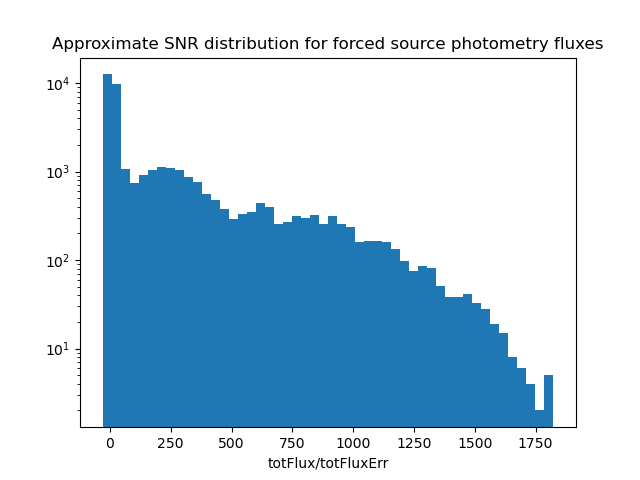

In [18]:
plt.figure()
plt.yscale('log')
totFluxHist = plt.hist(srcTable.totFluxSNR, bins=50)
plt.title('Approximate SNR distribution for forced source photometry fluxes')
plt.xlabel('totFlux/totFluxErr')